# Extended Wigner's friend scenario

An adapted notebook from Will pertaining to the extended Wigner's friend scenario.

This notebook is intended to run a benchmark to show a local friendliness violation from an extended Wigner's Friend scenario running on a QPU. For our friends we will use a GHZ state of increasing size. First we run on a simulator, then a noisy simulator, then on a real QPU.

Relevant References:
- [1]: ["A strong no-go theorem on the Wigner's friend paradox"](https://arxiv.org/abs/1907.05607)

- [2]: ["A scalable tripartite Wigner's friend scenario"](https://arxiv.org/abs/2109.02298)

- [3]: ["Thought experiments in a quantum computer"](https://arxiv.org/abs/2209.06236)

## Imports

In [1]:
import numpy as np
import itertools
import random
from enum import Enum
from tqdm import tqdm

import qiskit
import qiskit.providers.aer.noise as noise
from qiskit.providers import Backend
from qiskit_aer.noise import NoiseModel

## Constants

In [2]:
BACKEND = qiskit.Aer.get_backend("aer_simulator")

# Here is an example of a depolarizing noise model. 
# We can uncomment this when we've figured out the other violation equations.
# NOISE_MODEL = NoiseModel()
# # Add depolarizing error to all single qubit u1, u2, u3 gates
# error = noise.depolarizing_error(0.02, 1)
# NOISE_MODEL.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])

# Create an empty noise model
NOISE_MODEL = None

SHOTS = 10_000

In [3]:
# Settings for extended Wigner's friend scenario.
class Setting(Enum):
    PEEK = 1
    REVERSE_1 = 2
    REVERSE_2 = 3
PEEK = Setting.PEEK.value
REVERSE_1 = Setting.REVERSE_1.value
REVERSE_2 = Setting.REVERSE_2.value
SETTINGS = [PEEK, REVERSE_1, REVERSE_2]

In [4]:
# Observers for scenario are Alice and Bob.
class Observer(Enum):
    ALICE = 0
    BOB = 1
ALICE = Observer.ALICE.value
BOB = Observer.BOB.value
OBSERVERS = [ALICE, BOB]

In [5]:
# Size of the bipartite quantum system.
SYS_SIZE = 2

# Size of the systems held by the "friends" (Charlie and Debbie).
CHARLIE_SIZE = 1
DEBBIE_SIZE = 1

# Two output bits for Alice and Bob.
MEAS_SIZE = 2

# Size of entire circuit
CIRCUIT_SIZE = SYS_SIZE + CHARLIE_SIZE + DEBBIE_SIZE

# Angles and beta term used for Alice and Bob measurement operators from arXiv:1907.05607.
# Note that despite the fact that degrees are used, we need to convert this to radians.
ANGLES = {PEEK: np.deg2rad(168), REVERSE_1: np.deg2rad(0), REVERSE_2: np.deg2rad(118)}
BETA = np.deg2rad(175)

## Expectation values

In [6]:
def single_expect(observer: Observer, setting: Setting, results: dict):
    """Compute single expectation values for either Alice or Bob."""
    if observer == ALICE:
        ret = 0
        for settings in results.keys():
            if settings[ALICE] == setting:
                probs = results[settings]
                # <A> = P(00) + P(01) - P(10) - P(11)
                ret += (
                    probs.get("00", 0)
                    + probs.get("01", 0)
                    - probs.get("10", 0)
                    - probs.get("11", 0)
                )
        return ret / len(SETTINGS)
    else:
        ret = 0
        for settings in results.keys():
            if settings[BOB] == setting:
                probs = results[settings]
                # <B> = P(00) - P(01) + P(10) - P(11)
                ret += (
                    probs.get("00", 0)
                    - probs.get("01", 0)
                    + probs.get("10", 0)
                    - probs.get("11", 0)
                )
        return ret / len(SETTINGS)

In [90]:
def double_expect(settings: list[Setting], results: dict) -> float:
    """Expectation value of product of two operators."""
    probs = results[settings]
    # <AB> = P(00) - P(01) - P(10) + P(11)
    return (
        probs.get("00", 0) 
        - probs.get("01", 0) 
        - probs.get("10", 0) 
        + probs.get("11", 0)
    )    

## Consider all experimental settings

In [91]:
def generate_all_experiments(
    backend: Backend,
    noise_model: NoiseModel,
    shots: float,
    angles: list[float],
    beta: float
) -> dict[tuple[Observer, Observer], list[float]]:
    """Generate probabilitites for all combinations of experimental settings."""
    all_experiment_combos = list(itertools.product(SETTINGS, repeat=2))
    
    results = {}
    for alice, bob in all_experiment_combos:
        ewfs_circuit = ewfs(alice, bob, angles, beta)

        job = qiskit.execute(
            experiments=ewfs_circuit,
            backend=backend,
            noise_model=noise_model,
            basis_gates=noise_model.basis_gates if noise_model is not None else None,
            shots=shots,
        )
        counts = job.result().get_counts()
        
        # Convert counts to probabilities.
        probabilities = {key: value / shots for key, value in counts.items()}

        results[(alice, bob)] = probabilities
    return results

## State preparation

In [92]:
def prepare_bipartite_system() -> qiskit.QuantumCircuit:
    """Generates the state: 1/sqrt(2) * (|01> - |10>)"""
    qc = qiskit.QuantumCircuit(2)
    qc.x(0)
    qc.x(1)
    qc.h(0)
    qc.cx(0, 1)   
 
    return qc

Confirm that the state preparation circuit generates $|\psi\rangle = \frac{1}{\sqrt{2}}\left(|01\rangle - 10\rangle\right)$:

In [93]:
circuit = prepare_bipartite_system()
print(qiskit.Aer.get_backend("statevector_simulator").run(circuit).result().get_counts())

{'01': 0.5, '10': 0.5}


## CNOT ladder circuit

In [84]:
def cnot_ladder(system_qubit: int, friend_qubit: int, friend_size: int) -> qiskit.QuantumCircuit:
    """CNOT ladder circuit (GHZ without Hadamard)."""
    circuit = qiskit.QuantumCircuit(CIRCUIT_SIZE)
    for i in range(friend_size):
        circuit.cx(system_qubit, friend_qubit + i)
    return circuit

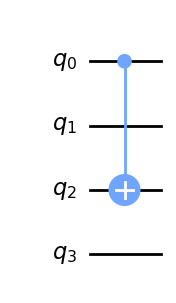

In [85]:
cnot_ladder(ALICE, SYS_SIZE, CHARLIE_SIZE).draw("mpl")

## Circuit for extended Wigner's friend scenario

In [150]:
def ewfs(alice_setting: Setting, bob_setting: Setting, angles: list[float], beta: float) -> qiskit.QuantumCircuit:
    """Generate the circuit for extended Wigner's friend scenario."""    
    # Observable circuits
    charlie_obs = cnot_ladder(ALICE, SYS_SIZE, CHARLIE_SIZE)
    debbie_obs = cnot_ladder(BOB, SYS_SIZE + CHARLIE_SIZE, DEBBIE_SIZE)
        
    # Initialize circuit that defines the extended scenario.
    qc = qiskit.QuantumCircuit(CIRCUIT_SIZE, MEAS_SIZE)
    
    # State prep
    qc = qc.compose(prepare_bipartite_system())    

    # Apply observable circuits for Charlie and Debbie.
    qc = qc.compose(charlie_obs)
    qc = qc.compose(debbie_obs)   
    
    # 0: Charlie system; 2: Charlie; [0]: Alice

    if alice_setting is PEEK:
        qc.rz(-angles[alice_setting], 2)
        qc.h(2) 
        qc.rz(angles[alice_setting], 2)

        # Ask Charlie for the outcome. We pick a random qubit from Charlie's register.
        random_offset = random.randint(0, CHARLIE_SIZE-1)
        qc.measure(SYS_SIZE + random_offset, ALICE)
    else:
        # Undo the measurement
        qc = qc.compose(charlie_obs)
        
        # For either REVERSE_1 or REVERSE_2, apply the appropriate angle rotations.
        qc.rz(-angles[alice_setting], ALICE)
        qc.h(ALICE)
        qc.rz(angles[alice_setting], ALICE)

        #qc.rx(np.pi/2, ALICE)
        
        qc.measure(ALICE, ALICE)
    
    # 1: Debbie system; 3: Debbie; [1]: Bob
    if bob_setting is PEEK:
        qc.rz(-(beta - angles[bob_setting]), 3)
        qc.h(3)        
        qc.rz((beta - angles[bob_setting]), 3)
        
        # Ask Debbie for the outcome. We pick a random qubit from Debbie's register.
        random_offset = random.randint(0, DEBBIE_SIZE-1)
        qc.measure(SYS_SIZE + CHARLIE_SIZE + random_offset, BOB)
    else:
        # Undo the measurement
        qc = qc.compose(debbie_obs)    

        # For either REVERSE_1 or REVERSE_2, apply the appropriate angle rotations.    
        qc.rz(-(beta - angles[bob_setting]), BOB)
        qc.h(BOB)
        qc.rz((beta - angles[bob_setting]), BOB)

        #qc.rx(np.pi/2, BOB)
        
        qc.measure(BOB, BOB)    
        
    return qc

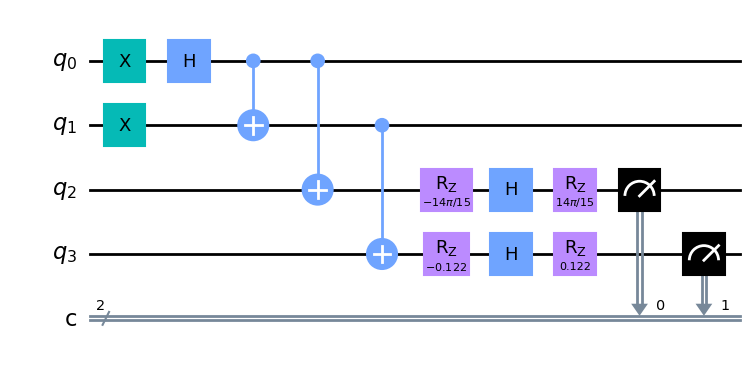

In [151]:
qc = ewfs(PEEK, PEEK, ANGLES, BETA)
qc.draw("mpl")

## Inequalities

In [152]:
def compute_inequalities(results, verbose=False):
    A1 = single_expect(ALICE, PEEK, results)
    B1 = single_expect(BOB, PEEK, results)

    A2 = single_expect(ALICE, REVERSE_1, results)
    B2 = single_expect(BOB, REVERSE_1, results)

    A3 = single_expect(ALICE, REVERSE_2, results)
    B3 = single_expect(BOB, REVERSE_2, results)

    A1B1 = double_expect((PEEK, PEEK), results)
    A1B2 = double_expect((PEEK, REVERSE_1), results)
    A1B3 = double_expect((PEEK, REVERSE_2), results)

    A2B1 = double_expect((REVERSE_1, PEEK), results)
    A2B2 = double_expect((REVERSE_1, REVERSE_1), results)
    A2B3 = double_expect((REVERSE_1, REVERSE_2), results)

    A3B1 = double_expect((REVERSE_2, PEEK), results)
    A3B2 = double_expect((REVERSE_2, REVERSE_1), results)
    A3B3 = double_expect((REVERSE_2, REVERSE_2), results)
    
    # Local-friendliness inequalities:
    # Eq. (13) from [1].
    lf_1 = -A1 - A2 - B1 - B2 - A1B1 - 2*A1B2 - 2*A2B1 + 2*A2B2 - A2B3 - A3B2 - A3B3 - 6
    # Eq. (14) from [1].
    lf_2 = -A1 - A2 - A3 - B1 - A1B1 - A2B1 - A3B1 - 2*A1B2 + A2B2 + A3B2 - A2B3 + A3B3 - 5
    # Eq. (15) from [1].
    lf_3 = -A1 + A2 + B1 - B2 + A1B1 - A1B2 - A1B3 - A2B1 + A2B2 - A2B3 - A3B1 - A3B2 - 4 
    # Eq. (16) from [1].
    lf_4 = -A2 - A3 - B2 - B3 - A1B2 + A1B3 - A2B1 - A2B2 - A2B3 + A3B1 - A3B2 - A3B3 - 4

    # Brukner inequalities:
    # Eq. (17) from [1].
    brukner = A1B1 - A1B3 - A2B1 - A2B3 - 2
    # Eq. (18) from [1].
    semi_brukner = -A1B2 + A1B3 - A3B2 - A3B3 - 2

    # Positivity inequalities:
    # Eq. (19) from [1].
    pos_1 = 1 + A1 + B1 + A1B1
    # Eq. (20) from [1].
    pos_2 = 1 + A1 + B2 + A1B2
    # Eq. (21) from [1].
    pos_3 = 1 + A2 + B2 + A2B2

    # Bell non-LF 
    # Eq. (22) from [1].
    bell_non_lf = A2B2 - A2B3 - A3B2 - A3B3 - 2
    
    if verbose:
        print("******Inequalities******")
        print(f"{semi_brukner=} -- is violated: {semi_brukner > 0}")
        print(f"{brukner=} -- is violated: {brukner > 0}")
        print(f"{lf_1=} -- is violated: {lf_1 > 0}")
        print(f"{lf_2=} -- is violated: {lf_2 > 0}")
        print(f"{lf_3=} -- is_violated: {lf_3 > 0}")
        print(f"{lf_4=} -- is_violated: {lf_4 > 0}")
        print(f"{pos_1=} -- is_violated: {pos_1 < 0}")
        print(f"{pos_2=} -- is_violated: {pos_2 < 0}")
        print(f"{pos_3=} -- is_violated: {pos_3 < 0}")
        print(f"{bell_non_lf=} -- is_violated: {bell_non_lf > 0}")
        print("**************************")
        
        print("******Expectation values******")
        print(f"{A1=}")
        print(f"{A2=}")
        print(f"{A3=}")
        print(f"{B1=}")
        print(f"{B2=}")
        print(f"{B3=}")
        print(f"{A1B1=}")
        print(f"{A1B2=}")
        print(f"{A1B3=}")
        print(f"{A2B1=}")
        print(f"{A2B2=}")
        print(f"{A2B3=}")
        print(f"{A3B1=}")
        print(f"{A3B2=}")
        print(f"{A3B3=}")
        print("******************************")

    any_violated = semi_brukner > 0 or brukner > 0 or lf_1 > 0 or lf_2 > 0 or \
    lf_3 > 0 or lf_4 > 0 or pos_1 < 0 or pos_2 < 0 or pos_3 < 0 or bell_non_lf > 0
    
    # These ones are the stubborn violations that refuse to be violated.
    stubborn_violated = brukner > 0 or lf_1 > 0 or lf_2 > 0 or lf_3 > 0 or pos_2 < 0 or bell_non_lf > 0
        
    return stubborn_violated

In [153]:
results = generate_all_experiments(backend=BACKEND, noise_model=NOISE_MODEL, shots=SHOTS, angles=ANGLES, beta=BETA)
compute_inequalities(results, verbose=True)

******Inequalities******
semi_brukner=-0.9609999999999999 -- is violated: False
brukner=-1.4815999999999998 -- is violated: False
lf_1=-2.3863999999999996 -- is violated: False
lf_2=-4.458866666666667 -- is violated: False
lf_3=-1.9279333333333333 -- is_violated: False
lf_4=-3.3953999999999995 -- is_violated: False
pos_1=0.9702 -- is_violated: False
pos_2=0.9872666666666666 -- is_violated: False
pos_3=1.9864000000000002 -- is_violated: False
bell_non_lf=0.5806000000000004 -- is_violated: True
**************************
******Expectation values******
A1=-0.0008000000000000415
A2=0.0009333333333333693
A3=-0.001666666666666645
B1=-0.003400000000000014
B2=-0.010733333333333359
B3=-0.010333333333333342
A1B1=-0.02560000000000001
A1B2=-0.0011999999999999789
A1B3=0.0005999999999999894
A2B1=0.0025999999999999635
A2B2=0.9962
A2B3=-0.5472
A3B1=-0.004599999999999993
A3B2=-0.5426000000000001
A3B3=-0.49460000000000004
******************************


True

## Experiment: Cycle angles

In [31]:
for angle_1 in np.linspace(0, 360, num=10):
    for angle_2 in tqdm(np.linspace(0, 360, num=10)):
        for angle_3 in np.linspace(0, 360, num=10):
            for beta in np.linspace(0, 360, num=10):
                
                angles = {PEEK: np.deg2rad(angle_1), REVERSE_1: np.deg2rad(angle_2), REVERSE_2: np.deg2rad(angle_3)}
                beta = np.deg2rad(beta)                
                results = generate_all_experiments(
                    backend=BACKEND, noise_model=NOISE_MODEL, shots=SHOTS, angles=angles, beta=beta
                )
                if compute_inequalities(results):
                    print("Found!")
                    print(f"{angle_1=} -- {angle_2=} -- {angle_3=} -- {beta=}")                

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:08<00:00,  6.84s/it]
